# Code to download LS8 images for Greenland peripheral glaciers using Amazon Web Services (aws) 

### Jukes Liu

The following code automatically downloads Landsat 8 scenes available through Amazon Web Services that have less than a threshold % of cloud cover. The Landsat 8 scenes over each glacier are identified using their pre-determined path and row, stored in a .csv file. The scenes are filtered for cloud cover using their metadata files.

## 1) Set up:

#### Install AWS using pip or pip3

Must have Amazon Web Services installed on your terminal. Follow instructions at https://docs.aws.amazon.com/cli/latest/userguide/install-linux-al2017.html to get aws commands onto your shell terminal.

#### Import packages

In [104]:
import pandas as pd
import numpy as np
import os
import subprocess
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy.ma as ma

#### Read in LS path and row for each peripheral glacier by BoxID into a DataFrame

The LS Path and Row information for each peripheral glacier is stored in a .csv file. 

Note: Many glaciers exist in the same Landsat scene, so some Paths and Rows are repeated. Therefore, the subsequent code will not repeat download for a path and row combination that already exists in the output directory.

In [105]:
#set basepath
basepath = '/home/jukes/Documents/Sample_glaciers/'
#basepath = '/home/automated-glacier-terminus/'
outputpath = '/media/jukes/jukes1/'

#read the path row csv file into a dataframe
pathrows_df = pd.read_csv(basepath+'LS_pathrows.csv', sep=',', usecols =[0,1,2], dtype=str, nrows =10)
pathrows_df = pathrows_df.set_index('BoxID')
pathrows_df

,Path,Row
BoxID,,
001,034,005
002,031,005
004,031,005
033,008,014
120,232,017
174,232,017
235,232,015
259,232,015
277,232,015


In [3]:
#check the df dimensions
pathrows_df.shape

(10, 2)

#### Create output directory: LS8aws

In [4]:
#create LS8aws folder
if os.path.exists(outputpath+'LS8aws')==True:
    print("Path exists already")
else:
    os.mkdir(outputpath+'LS8aws')
    print("LS8aws directory made")

Path exists already


## 2) Download B8 (panchromatic band) and MTL.txt (metadata) files for all available images over the path/row of the glaciers

The Landsat8 scenes stored in AWS can be accessed using the landsat-pds bucket and the path and row information. Each of the bands and a metadata file can be accessed separately. 

We are interested in the panchromatic band (B8.TIF) and the metadata file to filter for cloud cover (MTL.txt). The download commands will use the following syntax:


    aws --no-sign-request s3 cp s3://landsat-pds/L8/path/row/LC8pathrowyear001LGN00/LC8pathrowyear001LGN00_MTL.txt /path_to/output/

    aws --no-sign-request s3 cp s3://landsat-pds/L8/path/row/LC8pathrowyear001LGN00/LC8pathrowyear001LGN00_B8.TIF /path_to/output/

Access https://docs.opendata.aws/landsat-pds/readme.html to learn more.

### 2A) For one BoxID (one glacier) at a time

In [18]:
#choose a glacier: Box001
BoxID = pathrows_df.index[0]
path = pathrows_df['Path'][0]
row = pathrows_df['Row'][0] 
print('BoxID ', BoxID, 'path', path, 'row', row)

#set path row folder name
folder_name = 'Path'+path+'_Row'+row
print(folder_name)

#set input path
bp_in = 's3://landsat-pds/L8/'
totalp_in = bp_in+path+'/'+row+'/'
print(totalp_in)

#set output path
bp_out = outputpath+'LS8aws/'+folder_name+'/'
print(bp_out)

BoxID  001 path 034 row 005
Path034_Row005
s3://landsat-pds/L8/034/005/
/media/jukes/jukes1/LS8aws/Path034_Row005/


#### Create the Path_Row folder

In [6]:
#create Path_row folder and write path names to txt files
if os.path.exists(bp_out):
    print(folder_name, " EXISTS ALREADY. SKIP.")
else:
    os.mkdir(bp_out)
    print(folder_name+" directory made")

Path034_Row005  EXISTS ALREADY. SKIP.


#### Download all the metadata text files using os.system aws commands

Use the following syntax:

    aws --no-sign-request s3 cp s3://landsat-pds/L8/031/005/ Output/path/LS8aws/Path031_Row005/ --recursive --exclude "*" --include "*.txt" 

In [ ]:
# #Check command syntax:
# command = 'aws --no-sign-request s3 cp '+totalp_in+' '+bp_out+' --recursive --exclude "*" --include "*.txt"'
# print(command)

In [ ]:
# #call the command line that downloads the metadata files using aws
# subprocess.call(command, shell=True)

#### Download BQA band to get cloud mask using os.system aws commands

Use the following syntax:

    aws --no-sign-request s3 cp s3://landsat-pds/L8/031/005/ Output/path/LS8aws/Path031_Row005/ --recursive --exclude "*" --include "*BQA.TIF" 

In [8]:
#Check command syntax:
command2 = 'aws --no-sign-request s3 cp '+totalp_in+' '+bp_out+' --recursive --exclude "*" --include "*BQA.TIF"'
print(command2)

aws --no-sign-request s3 cp s3://landsat-pds/L8/034/005/ /media/jukes/jukes1/LS8aws/Path034_Row005/ --recursive --exclude "*" --include "*BQA.TIF"


In [9]:
#call the command line that downloads the BQA files using aws
subprocess.call(command2, shell=True)

0

### Cloud filtering

#### Option 1) Filter for cloud cover using metadata cloud cover percentage

If the metadata files indicate land cloud cover is less than the threshold, then download the B8, otherwise, delete the folder. Not all metadata files contain the land cloud cover, some only contain the overall cloud cover. If land cloud cover is not found, use the cloud cover value to determine whether the image should be downloaded .Use the following metadata attributes:

  GROUP = IMAGE_ATTRIBUTES
  
    CLOUD_COVER = 23.58
    CLOUD_COVER_LAND = 20.41

Set cloud cover % thresholds and paths:

In [ ]:
# #set cloud cover % thresholds
# ccland_thresh = 30.0
# cc_thresh = 50.0

# #set paths:
# #set path row folder name
# folder_name = 'Path'+path+'_Row'+row
# print(folder_name)

# #set input path
# bp_in = 's3://landsat-pds/L8/'
# totalp_in = bp_in+path+'/'+row+'/'
# print(totalp_in)

# #set output path
# bp_out = outputpath+'LS8aws/'+folder_name+'/'
# print(bp_out)

Loop, filter, download all images:

In [ ]:
# #loop through all the metadata files in the path_row folder:
# for image in os.listdir(bp_out):
#     if image.startswith("LC"):
#         #list the name of the image folder
#         print(image)
        
#         #open the metadata file within that folder
#         mdata = open(bp_out+image+"/"+image+"_MTL.txt", "r")
        
#         #set a detection variable for whether or not the metadata contains land cloud cover
#         ccl_detected = False
        
#         #loop through each line in metadata to find Land Cloud Cover
#         for line in mdata:
#             cc_variable = line.split("=")[0]
            
#             #if there is land cloud cover:
#             if ("CLOUD_COVER_LAND" in cc_variable):
#                 #save it:
#                 ccl = np.float(line.split("=")[1])
                         
#                 #switch the ccl_detected variable to True!
#                 ccl_detected = True
                    
#                 #if the ccl is less than the threshold, delete the file
#                 if ccl > ccland_thresh:
#                     #remove the image directory
#                     subprocess.call('rm -r '+bp_out+image, shell=True)
#                     print(ccl, ' > ', ccland_thresh, ", ", image, "removed")
#                 #otherwise: 
#                 else:
#                     #DOWNLOAD THE B8 FILE
#                     subprocess.call('source activate aws; aws --no-sign-request s3 cp '+totalp_in+' '+bp_out+' --recursive --exclude "*" --include "*B8.TIF"', shell=True)
#                     print(image, "B8 downloaded -ccl ")
        
#         #Was the ccl detected?
#         print("CCL detected = ", ccl_detected)
                        
#         #if False,use the overall cloud cover:
#         if ccl_detected == False:   
#             print("CCL not detected, use CC.")
            
#             #open the metadata file again
#             mdata = open(bp_out+image+"/"+image+"_MTL.txt", "r")
#             for line in mdata:
#                 variable = line.split("=")[0]
                
#                 #now there should only be one line starting with cloud_cover
#                 if ("CLOUD_COVER" in variable):       
#                     #save the cloud cover:
#                     cc = np.float(line.split("=")[1])

#                     #if the cc is less than the threshold, delete the file:
#                     if cc > cc_thresh:
#                         #remove the image directory
#                         subprocess.call('rm -r '+bp_out+image, shell=True)
#                         print(cc, ' > ', cc_thresh, ", ", image, "removed")

#                     #otherwise: 
#                     else:
#                         #DOWNLOAD THE B8 FILE
#                         subprocess.call('source activate aws; aws --no-sign-request s3 cp '+totalp_in+' '+bp_out+' --recursive --exclude "*" --include "*B8.TIF"', shell=True)
#                         print(image, "B8 downloaded -cc")
# print('Done.')

#### Option 2) Filter for cloud cover using BQA cloud info

The Landsat-8 BQA band includes a basic classification of surface types. These classes include water, snow/ice, and cloud. The values for cloud pixels are higher than others, > 50,000 in the 16-bit images. Therefore, we calculate the percentage of cloud pixels in each glacier's terminus box. If the percentage is above the threshold, we remove the directory and do not download the image. If the percentage is lower than the threshold, then we download the panchromatic image.

Set cloud percentage threshold:

In [106]:
cpercent_thresh = 20.0

Load terminus box shapefile for subsetting and load the raster to count total number of pixels within the box:

In [107]:
#set path to terminus box shp
boxpath = basepath+'Box'+BoxID+'/Box'+BoxID+'.shp'
print(boxpath)

#set path to terminus box raster
boxrasterpath = basepath+'Box'+BoxID+'/Box'+BoxID+'_raster_cut.png'
print(boxrasterpath)

/home/jukes/Documents/Sample_glaciers/Box001/Box001.shp
/home/jukes/Documents/Sample_glaciers/Box001/Box001_raster_cut.png


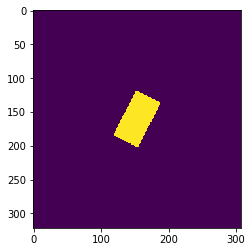

Total number of pixels in the raster: 3023


In [97]:
#load in box raster and count where raster == 1 using np.count_nonzero
#read the raster into an ndarray
termbox = mpimg.imread(boxrasterpath)
termplot = plt.imshow(termbox)
plt.show()

totalpixels = np.count_nonzero(termbox)
#print(termbox.shape[0]*termbox.shape[1])
print('Total number of pixels in the raster:',totalpixels)

Re-project and subset the BQA band to the glacier BOI terminus box using GDAL commands with syntax:

1) Reproject into Greenland Polar Stereographic projection

    gdalwarp -t_srs ‘+proj=stere +lat_ts=70 +lat_0=90 +lon_0=-45 +y=0 +x=0 +k=1 +datum=WGS84 +units=m’ path_to_input_BQA.TIF path_to_renamed_output_BQA.TIF

2) Subset

    gdalwarp -cutline path_to_Box###.shp -crop_to_cutline path_to_BQA.TIF path_to_result_BQA.TIF

Then calculate the number of cloud pixels

In [108]:
#export GDAL path command:
export_GDALpath = 'export PATH=/Library/Frameworks/GDAL.framework/Programs:$PATH ; '

#loop through all the metadata files in the path_row folder:
for image in os.listdir(bp_out):
    if image.startswith("LC"):
        #list the name of the image folder
#         print(image)

        #set the path to the BQA band
        bandpath = bp_out+image+'/'
        
        for band in os.listdir(bandpath):
            if band.endswith("BQA.TIF"):
                print(band)
                
                bandpath = bandpath+band
                rp_bandpath = bandpath[:-4]+"_PS.TIF"
                cut_rp_bandpath = rp_bandpath[:-4]+"_Box"+BoxID+".TIF"
#                 print(bandpath)
#                 print(rp_bandpath)
#                 print(cut_rp_bandpath)
                
#                 #reproject the band:
#                 reproject_cmd = "gdalwarp -t_srs '+proj=stere +lat_ts=70 +lat_0=90 +lon_0=-45 +y=0 +x=0 +k=1 +datum=WGS84 +units=m' "+bandpath+" "+rp_bandpath
# #                 print(export_GDALpath+reproject_cmd)
#                 subprocess.call(export_GDALpath+reproject_cmd, shell=True)
#                 print('BQA reprojected')

#                 #subset the reprojected BQA band to terminus box:
#                 subsetBQA_cmd = 'gdalwarp -cutline '+boxpath+' -crop_to_cutline '+rp_bandpath+" "+cut_rp_bandpath
# #                 print(export_GDALpath+subsetBQA_cmd)
#                 subprocess.call(export_GDALpath+subsetBQA_cmd, shell=True)
#                 print('BQA subset')
        
                #load the subset BQA band and mask out any values that are less than 50000 (clouds)
                subsetBQA = mpimg.imread(cut_rp_bandpath)
                cloudBQA = subsetBQA[subsetBQA >= 50000]
#                 print(cloudBQA)
                
                #count the number of cloud pixels
                cloudpixels = len(cloudBQA)
#                 print(cloudpixels)
                
                #calculate divided by the total
                cloudpercent = cloudpixels/totalpixels*100
                print('Cloud % in box:', cloudpercent)
                
                #if statement cloud percent is greater than the threshold, delete the folder:
                if cloudpercent > cpercent_thresh:
                    #remove the image directory
                    subprocess.call('rm -r '+bp_out+image, shell=True)
                    print(cloudpercent, ' > ', cpercent_thresh, ", ", image, "removed")
                #otherwise: 
                else:
                    #DOWNLOAD THE B8 FILE
                    subprocess.call('source activate aws; aws --no-sign-request s3 cp '+totalp_in+' '+bp_out+' --recursive --exclude "*" --include "*B8.TIF"', shell=True)
                    print(image, "B8 downloaded")
                    

LC80340052014215LGN00_BQA.TIF
Cloud % in box: 6.45054581541515


KeyboardInterrupt: 

### 2B) For ALL glaciers:

#### Option 1: Metadata cloud cover % threshold

In [ ]:
# #SET cloud cover thresholds for filtering
# ccland_thresh = 30.0
# cc_thresh = 50.0



# #LOOP through each of the glaciers in the DataFrame and download for each path and row
# for i in range(0, len(pathrows_df.index)):
#     #SET path and row variables to the LS path and rows of the box
#     path = pathrows_df['Path'][i]
#     row = pathrows_df['Row'][i]
#     #print(path, row)
    
#     #1) CREATE path and row folders to download into and set input output paths
#     #SET path row folder name
#     folder_name = 'Path'+path+'_Row'+row
#     print(folder_name)
    
#     #SET input path
#     bp_in = 's3://landsat-pds/L8/'
#     totalp_in = bp_in+path+'/'+row+'/'
#     #print(totalp_in)

#     #SET output path
#     bp_out = outputpath+'LS8aws/'+folder_name+'/'
    
    
    
#     #IF the folder exists, it's already been downloaded, do not attempt download.
#     if os.path.exists(bp_out):
#         print(folder_name, " EXISTS ALREADY. SKIP.")
#     #2) OTHERWISE, create the folder and download into it
#     else:
#         os.mkdir(bp_out)
#         print(folder_name+" directory made")

        
#         #3) DOWNLOAD metadata files into the new path-row folder
#         #CHECK COMMAND SYNTAX
#         command = 'source activate aws; aws --no-sign-request s3 cp '+totalp_in+' '+bp_out+' --recursive --exclude "*" --include "*.txt"'
#         #print(command)
#         subprocess.call(command, shell=True)
        
        
        
#         #4) LOOP through all the files in the path_row folder to download based on cloud cover
#         # in the metadata files
#         for image in os.listdir(bp_out):
#             if image.startswith("LC"):
#                 #list the name of the image folder
#                 print(image)

#                 #open the metadata file within that folder
#                 mdata = open(bp_out+image+"/"+image+"_MTL.txt", "r")

#                 #set a detection variable for whether or not the metadata contains land cloud cover
#                 ccl_detected = False

#                 #loop through each line in metadata to find the land cloud cover
#                 for line in mdata:
#                     cc_variable = line.split("=")[0]

#                     #if there is land cloud cover:
#                     if ("CLOUD_COVER_LAND" in cc_variable):
#                         #save it:
#                         ccl = np.float(line.split("=")[1])

#                         #switch the ccl detected variable to True
#                         ccl_detected = True

#                         #if the ccl is less than the threshold, delete the file
#                         if ccl > ccland_thresh:
#                             #remove the image directory
#                             #subprocess.call('rm -r '+bp_out+image, shell=True)
#                             print(ccl, ' > ', ccland_thresh, ", ", image, "removed")
#                         #otherwise: 
#                         else:
#                             #download the B8 file
#                             subprocess.call('source activate aws; aws --no-sign-request s3 cp '+totalp_in+' '+bp_out+' --recursive --exclude "*" --include "*B8.TIF"', shell=True)
#                             print(image, "B8 downloaded -ccl ")

#                 print("CCL detected = ", ccl_detected)

#                 #if False,use the overall cloud cover:
#                 if ccl_detected == False:   
#                     print("CCL not detected, use CC.")

#                     #open the metadata file again
#                     mdata = open(bp_out+image+"/"+image+"_MTL.txt", "r")
#                     for line in mdata:
#                         variable = line.split("=")[0]

#                         #now there should only be one line starting with cloud_cover
#                         if ("CLOUD_COVER" in variable):       
#                             #save the cloud cover:
#                             cc = np.float(line.split("=")[1])

#                             #if the cc is less than the threshold, delete the file:
#                             if cc > cc_thresh:
#                                 #remove the image directory
#                                 #subprocess.call('rm -r '+bp_out+image, shell=True)
#                                 print(cc, ' > ', cc_thresh, ", ", image, "removed")

#                             #otherwise: 
#                             else:
#                                 #DOWNLOAD THE B8 FILE
#                                 subprocess.call('source activate aws; aws --no-sign-request s3 cp '+totalp_in+' '+bp_out+' --recursive --exclude "*" --include "*B8.TIF"', shell=True)
#                                 print(image, "B8 downloaded -cc")

#### Option 2: BQA cloud cover threshold

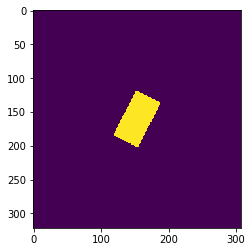

Total number of pixels in the raster: 3023
/media/jukes/jukes1/LS8aws/Box001/LC80340052014215LGN00/
LC80340052014215LGN00_BQA.TIF
BQA reprojected
BQA subset
Cloud % in box: 6.45054581541515
LC80340052014215LGN00 B8 downloaded
/media/jukes/jukes1/LS8aws/Box001/LC80340052013148LGN00/
LC80340052013148LGN00_BQA.TIF
BQA reprojected
BQA subset
Cloud % in box: 0.09923916639100232
LC80340052013148LGN00 B8 downloaded
/media/jukes/jukes1/LS8aws/Box001/LC80340052016125LGN00/
LC80340052016125LGN00_BQA.TIF
BQA reprojected
BQA subset
Cloud % in box: 0.06615944426066822
LC80340052016125LGN00 B8 downloaded
/media/jukes/jukes1/LS8aws/Box001/LC80340052014183LGN00/
LC80340052014183LGN00_BQA.TIF
BQA reprojected
BQA subset
Cloud % in box: 25.736023817399932
25.736023817399932  >  20.0 ,  LC80340052014183LGN00 removed
/media/jukes/jukes1/LS8aws/Box001/LC80340052014135LGN00/
LC80340052014135LGN00_BQA.TIF
BQA reprojected
BQA subset
Cloud % in box: 25.967581872312273
25.967581872312273  >  20.0 ,  LC8034005201

LC80340052017063LGN00 B8 downloaded
/media/jukes/jukes1/LS8aws/Box001/LC80340052016173LGN00/
LC80340052016173LGN00_BQA.TIF
BQA reprojected
BQA subset
Cloud % in box: 25.206748263314587
25.206748263314587  >  20.0 ,  LC80340052016173LGN00 removed


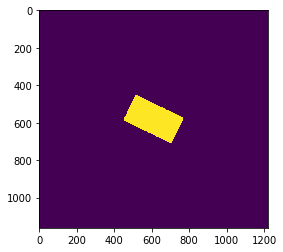

Total number of pixels in the raster: 43558
/media/jukes/jukes1/LS8aws/Box002/LC80310052014146LGN00/
LC80310052014146LGN00_BQA.TIF
BQA reprojected
BQA subset
Cloud % in box: 21.642407824050693
21.642407824050693  >  20.0 ,  LC80310052014146LGN00 removed
/media/jukes/jukes1/LS8aws/Box002/LC80310052017074LGN00/
LC80310052017074LGN00_BQA.TIF
BQA reprojected
BQA subset
Cloud % in box: 2.7916800587722115
LC80310052017074LGN00 B8 downloaded
/media/jukes/jukes1/LS8aws/Box002/LC80310052016168LGN00/
LC80310052016168LGN00_BQA.TIF
BQA reprojected
BQA subset
Cloud % in box: 23.39639101887139
23.39639101887139  >  20.0 ,  LC80310052016168LGN00 removed
/media/jukes/jukes1/LS8aws/Box002/LC80310052016232LGN00/
LC80310052016232LGN00_BQA.TIF
BQA reprojected
BQA subset
Cloud % in box: 24.890949997704208
24.890949997704208  >  20.0 ,  LC80310052016232LGN00 removed
/media/jukes/jukes1/LS8aws/Box002/LC80310052016120LGN00/
LC80310052016120LGN00_BQA.TIF
BQA reprojected
BQA subset
Cloud % in box: 2.43353689333

LC80310052014194LGN00 B8 downloaded


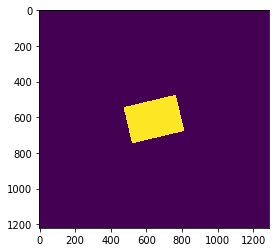

Total number of pixels in the raster: 62624
/media/jukes/jukes1/LS8aws/Box004/LC80310052014146LGN00/
LC80310052014146LGN00_BQA.TIF
BQA reprojected
BQA subset
Cloud % in box: 0.0015968318855390906
LC80310052014146LGN00 B8 downloaded
/media/jukes/jukes1/LS8aws/Box004/LC80310052017074LGN00/
LC80310052017074LGN00_BQA.TIF
BQA reprojected
BQA subset
Cloud % in box: 3.6232115482881957
LC80310052017074LGN00 B8 downloaded
/media/jukes/jukes1/LS8aws/Box004/LC80310052016168LGN00/
LC80310052016168LGN00_BQA.TIF
BQA reprojected
BQA subset
Cloud % in box: 15.498850281042412
LC80310052016168LGN00 B8 downloaded
/media/jukes/jukes1/LS8aws/Box004/LC80310052016232LGN00/
LC80310052016232LGN00_BQA.TIF
BQA reprojected
BQA subset
Cloud % in box: 22.96723300970874
22.96723300970874  >  20.0 ,  LC80310052016232LGN00 removed
/media/jukes/jukes1/LS8aws/Box004/LC80310052016120LGN00/
LC80310052016120LGN00_BQA.TIF
BQA reprojected
BQA subset
Cloud % in box: 25.68504087889627
25.68504087889627  >  20.0 ,  LC8031005201

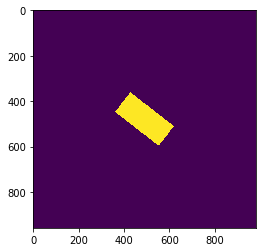

Total number of pixels in the raster: 26787
/media/jukes/jukes1/LS8aws/Box033/LC80080142016311LGN00/
LC80080142016311LGN00_BQA.TIF
BQA reprojected
BQA subset
Cloud % in box: 15.5187217680218
LC80080142016311LGN00 B8 downloaded
/media/jukes/jukes1/LS8aws/Box033/LC80080142014177LGN00/
LC80080142014177LGN00_BQA.TIF
BQA reprojected
BQA subset
Cloud % in box: 24.23563668943891
24.23563668943891  >  20.0 ,  LC80080142014177LGN00 removed
/media/jukes/jukes1/LS8aws/Box033/LC80080142015132LGN00/
LC80080142015132LGN00_BQA.TIF
BQA reprojected
BQA subset
Cloud % in box: 21.170717138910668
21.170717138910668  >  20.0 ,  LC80080142015132LGN00 removed
/media/jukes/jukes1/LS8aws/Box033/LC80080142015292LGN00/
LC80080142015292LGN00_BQA.TIF
BQA reprojected
BQA subset
Cloud % in box: 0.4554448053160115
LC80080142015292LGN00 B8 downloaded
/media/jukes/jukes1/LS8aws/Box033/LC80080142015148LGN00/
LC80080142015148LGN00_BQA.TIF
BQA reprojected
BQA subset
Cloud % in box: 0.6085041251353268
LC80080142015148LGN00

BQA reprojected
BQA subset
Cloud % in box: 0.5786388919998507
LC80080142015196LGN00 B8 downloaded
/media/jukes/jukes1/LS8aws/Box033/LC80080142017105LGN00/
LC80080142017105LGN00_BQA.TIF
BQA reprojected
BQA subset
Cloud % in box: 0.06719677455482137
LC80080142017105LGN00 B8 downloaded
/media/jukes/jukes1/LS8aws/Box033/LC80080142015244LGN00/
LC80080142015244LGN00_BQA.TIF
BQA reprojected
BQA subset
Cloud % in box: 0.23145555679994026
LC80080142015244LGN00 B8 downloaded
/media/jukes/jukes1/LS8aws/Box033/LC80080142015116LGN00/
LC80080142015116LGN00_BQA.TIF
BQA reprojected
BQA subset
Cloud % in box: 0.17919139881285698
LC80080142015116LGN00 B8 downloaded
/media/jukes/jukes1/LS8aws/Box033/LC80080142015068LGN00/
LC80080142015068LGN00_BQA.TIF
BQA reprojected
BQA subset
Cloud % in box: 24.239369843580842
24.239369843580842  >  20.0 ,  LC80080142015068LGN00 removed
/media/jukes/jukes1/LS8aws/Box033/LC80080142017089LGN00/
LC80080142017089LGN00_BQA.TIF
BQA reprojected
BQA subset
Cloud % in box: 9.68

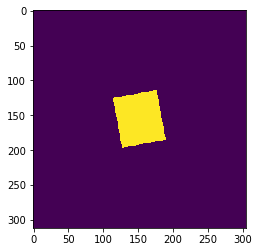

Total number of pixels in the raster: 4611
/media/jukes/jukes1/LS8aws/Box120/LC82320172014066LGN00/
LC82320172014066LGN00_BQA.TIF
BQA reprojected
BQA subset
Cloud % in box: 0.13012361743656475
LC82320172014066LGN00 B8 downloaded
/media/jukes/jukes1/LS8aws/Box120/LC82320172016024LGN00/
LC82320172016024LGN00_BQA.TIF
BQA reprojected
BQA subset
Cloud % in box: 0.0
LC82320172016024LGN00 B8 downloaded
/media/jukes/jukes1/LS8aws/Box120/LC82320172016248LGN00/
LC82320172016248LGN00_BQA.TIF
BQA reprojected
BQA subset
Cloud % in box: 23.877683799609628
23.877683799609628  >  20.0 ,  LC82320172016248LGN00 removed
/media/jukes/jukes1/LS8aws/Box120/LC82320172013319LGN00/
LC82320172013319LGN00_BQA.TIF
BQA reprojected
BQA subset
Cloud % in box: 4.467577531988723
LC82320172013319LGN00 B8 downloaded
/media/jukes/jukes1/LS8aws/Box120/LC82320172013255LGN00/
LC82320172013255LGN00_BQA.TIF
BQA reprojected
BQA subset
Cloud % in box: 0.3903708523096942
LC82320172013255LGN00 B8 downloaded
/media/jukes/jukes1/LS

BQA reprojected
BQA subset
Cloud % in box: 0.8458035133376708
LC82320172015197LGN00 B8 downloaded
/media/jukes/jukes1/LS8aws/Box120/LC82320172015277LGN00/
LC82320172015277LGN00_BQA.TIF
BQA reprojected
BQA subset
Cloud % in box: 0.6939926263283452
LC82320172015277LGN00 B8 downloaded
/media/jukes/jukes1/LS8aws/Box120/LC82320172016104LGN00/
LC82320172016104LGN00_BQA.TIF
BQA reprojected
BQA subset
Cloud % in box: 0.0
LC82320172016104LGN00 B8 downloaded
/media/jukes/jukes1/LS8aws/Box120/LC82320172016168LGN00/
LC82320172016168LGN00_BQA.TIF
BQA reprojected
BQA subset
Cloud % in box: 23.443938408154413
23.443938408154413  >  20.0 ,  LC82320172016168LGN00 removed
/media/jukes/jukes1/LS8aws/Box120/LC82320172015149LGN00/
LC82320172015149LGN00_BQA.TIF
BQA reprojected
BQA subset
Cloud % in box: 0.3686835827369334
LC82320172015149LGN00 B8 downloaded
/media/jukes/jukes1/LS8aws/Box120/LC82320172016328LGN00/
LC82320172016328LGN00_BQA.TIF
BQA reprojected
BQA subset
Cloud % in box: 0.1734981565820863
LC8

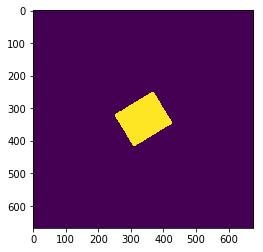

Total number of pixels in the raster: 16017
/media/jukes/jukes1/LS8aws/Box174/LC82320172014066LGN00/
LC82320172014066LGN00_BQA.TIF
BQA reprojected
BQA subset
Cloud % in box: 0.11862396204033215
LC82320172014066LGN00 B8 downloaded
/media/jukes/jukes1/LS8aws/Box174/LC82320172016024LGN00/
LC82320172016024LGN00_BQA.TIF
BQA reprojected
BQA subset
Cloud % in box: 0.0
LC82320172016024LGN00 B8 downloaded
/media/jukes/jukes1/LS8aws/Box174/LC82320172016248LGN00/
LC82320172016248LGN00_BQA.TIF
BQA reprojected
BQA subset
Cloud % in box: 22.975588437285385
22.975588437285385  >  20.0 ,  LC82320172016248LGN00 removed
/media/jukes/jukes1/LS8aws/Box174/LC82320172013319LGN00/
LC82320172013319LGN00_BQA.TIF
BQA reprojected
BQA subset
Cloud % in box: 0.6118499094711869
LC82320172013319LGN00 B8 downloaded
/media/jukes/jukes1/LS8aws/Box174/LC82320172013255LGN00/
LC82320172013255LGN00_BQA.TIF
BQA reprojected
BQA subset
Cloud % in box: 23.244053193481925
23.244053193481925  >  20.0 ,  LC82320172013255LGN00 rem

In [ ]:
#SET cloud cover threshold
cpercent_thresh = 20.0


#LOOP through each of the glaciers in the DataFrame and download for each path and row
for i in range(0, len(pathrows_df.index)):
    #SET path and row variables to the LS path and rows of the box
    path = pathrows_df['Path'][i]
    row = pathrows_df['Row'][i]
    BoxID = pathrows_df.index[i]
#     print(path, row, BoxID)
    
    #1) CREATE path and row folders to download into and set input output paths
    #SET path row folder name
    folder_name = 'Path'+path+'_Row'+row
#     print(folder_name)
    
    #SET input path
    bp_in = 's3://landsat-pds/L8/'
    totalp_in = bp_in+path+'/'+row+'/'
    #print(totalp_in)

    #SET output path
    bp_out = outputpath+'LS8aws/Box'+BoxID+'/'
    
    #Download all the metadata files
    # #Check command syntax:
    dwn_command = 'aws --no-sign-request s3 cp '+totalp_in+' '+bp_out+' --recursive --exclude "*" --include "*.txt"'
#     print(dwn_command)
    subprocess.call(dwn_command, shell=True)
    
     
    #IF the folder exists, it's already been downloaded, do not attempt download.
    if os.path.exists(bp_out):
#         print(folder_name, " EXISTS ALREADY. SKIP.")
#     #2) OTHERWISE, create the folder and download into it
#     else:
#         os.mkdir(bp_out)
#         print(folder_name+" directory made")

        
        #3) DOWNLOAD BQA files into the new path-row folder
        #CHECK COMMAND SYNTAX
        command2 = 'aws --no-sign-request s3 cp '+totalp_in+' '+bp_out+' --recursive --exclude "*" --include "*BQA.TIF"'
#         print(command2)
        subprocess.call(command2, shell=True)
        
                
        #4) CALCULATE CLOUD COVER IN TERMINUS BOX
        #set path to terminus box shp
        boxpath = basepath+'Box'+BoxID+'/Box'+BoxID+'.shp'
#         print(boxpath)

        #set path to terminus box raster
        boxrasterpath = basepath+'Box'+BoxID+'/Box'+BoxID+'_raster_cut.png'
#         print(boxrasterpath)
                
        #load in box raster and count where raster == 1 using np.count_nonzero
        #read the raster into an ndarray
        termbox = mpimg.imread(boxrasterpath)
        termplot = plt.imshow(termbox)
        plt.show()

        totalpixels = np.count_nonzero(termbox)
        #print(termbox.shape[0]*termbox.shape[1])
        print('Total number of pixels in the raster:',totalpixels)
        
        #export GDAL path command:
        export_GDALpath = 'export PATH=/Library/Frameworks/GDAL.framework/Programs:$PATH ; '

        #loop through all the BQA files in the path_row folder:
        for image in os.listdir(bp_out):
            if image.endswith("00"):
                #list the name of the image folder
        #         print(image)

                #set the path to the BQA band
                bandpath = bp_out+image+'/'
                print(bandpath)

                for band in os.listdir(bandpath):
                    if band.endswith("BQA.TIF"):
                        print(band)

                        bandpath = bandpath+band
                        rp_bandpath = bandpath[:-4]+"_PS.TIF"
                        cut_rp_bandpath = rp_bandpath[:-4]+"_Box"+BoxID+".TIF"
        #                 print(bandpath)
        #                 print(rp_bandpath)
        #                 print(cut_rp_bandpath)

        #                 #reproject the band:
                        reproject_cmd = "gdalwarp -t_srs '+proj=stere +lat_ts=70 +lat_0=90 +lon_0=-45 +y=0 +x=0 +k=1 +datum=WGS84 +units=m' "+bandpath+" "+rp_bandpath
        #                 print(export_GDALpath+reproject_cmd)
                        subprocess.call(export_GDALpath+reproject_cmd, shell=True)
                        print('BQA reprojected')

                        #subset the reprojected BQA band to terminus box:
                        subsetBQA_cmd = 'gdalwarp -cutline '+boxpath+' -crop_to_cutline '+rp_bandpath+" "+cut_rp_bandpath
        #                 print(export_GDALpath+subsetBQA_cmd)
                        subprocess.call(export_GDALpath+subsetBQA_cmd, shell=True)
                        print('BQA subset')

                        #load the subset BQA band and mask out any values that are less than 50000 (clouds)
                        subsetBQA = mpimg.imread(cut_rp_bandpath)
                        cloudBQA = subsetBQA[subsetBQA >= 50000]
        #                 print(cloudBQA)

                        #count the number of cloud pixels
                        cloudpixels = len(cloudBQA)
        #                 print(cloudpixels)

                        #calculate divided by the total
                        cloudpercent = cloudpixels/totalpixels*100
                        print('Cloud % in box:', cloudpercent)
                        
                        #SWITCH THESE TWO
                        #5) IF cloud percent is greater than the threshold, delete the folder:
                        if cloudpercent > cpercent_thresh:
                            #remove the image directory
                            subprocess.call('rm -r '+bp_out+image, shell=True)
                            print(cloudpercent, ' > ', cpercent_thresh, ", ", image, "removed")
                        #otherwise: 
                        else:
                            #DOWNLOAD THE B8 FILE
                            subprocess.call('source activate aws; aws --no-sign-request s3 cp '+totalp_in+' '+bp_out+' --recursive --exclude "*" --include "*B8.TIF"', shell=True)
                            print(image, "B8 downloaded")
        

## 3) Grab image dates from the metadata

In [ ]:
import datetime

#create dictionary of datetime objects for the images:
datetime_objs = {}

#LOOP through each of the glaciers in the DataFrame and download for each path and row
for i in range(0, len(pathrows_df.index)):
    #SET path and row variables to the LS path and rows of the box
    path = pathrows_df['Path'][i]
    row = pathrows_df['Row'][i]
    BoxID = pathrows_df.index[i]
    #print(path, row)
    
    #SET path row folder name
    folder_name = 'Path'+path+'_Row'+row
#     print(folder_name)
    
    #SET output path
    bp_out = outputpath+'LS8aws/Box'+BoxID+'/'
        
    # LOOP through all the metadata files to grab the image dates
    # in the metadata files
    for scene in os.listdir(bp_out):
        if folder_name.startswith("Path") and scene.endswith("00"):
            #list the name of the image folder
#             print(scene)
            scenetag = scene[8:19]
#             print(scenetag)
            scenecount = scenecount+1

            #open the metadata file within that folder
            for file in os.listdir(bp_out+scene+"/"):                
                if ("MTL.txt" in file):
                    
                    mdata = open(bp_out+scene+"/"+scene+"_MTL.txt", "r")

                    #loop through each line in metadata to find the date and time of acquisition
                    for line in mdata:
                        variable = line.split("=")[0]

                        if ("DATE_ACQUIRED" in variable):
                            #save it:
                            date = line.split("=")[1][1:-1]
#                             print(date)

                        #if ("SCENE_CENTER_TIME" in variable): 
                            #save it:
                            #time = line.split("=")[1][2:-2]
                            #print(time)
                
                    #combine them into a datetime object
                    datetime_obj = datetime.datetime.strptime(date, '%Y-%m-%d')
                    datetime_objs.update( {scene[4:-5]: datetime_obj} )
                         
datetime_df = pd.DataFrame.from_dict(datetime_objs, orient='index')
datetime_df

Export image dates to .csv

In [72]:
datetime_df.to_csv(path_or_buf = basepath+'datetags.csv', sep=',')

## For download using Google instead, follow these instructions:

Use gsutil: https://krstn.eu/landsat-batch-download-from-google/

To access a scene for Path 124, Row 053, use this syntax:

gsutil cp -n gs://earthengine-public/landsat/L8/124/053/LC81240532013107LGN01.tar.bz /landsat/
